In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tik
from datetime import datetime, timezone, timedelta

from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.mlab as mlab

#from matplotlib import gridspec

# Input data, log and these forms

In [2]:
#file path and name
filepath = './rawdata/'
filename = 'Jan19_absolute2.dat'

logpath = './log/'
logfilename = 'PMX_2021-01-19.dat'

In [3]:
storepath = './plots/'
storename = 'Jan19_absolute2'

In [4]:
#rawdata
time_category0, error0, direction0, timercount0, reference0 = np.loadtxt(filepath + filename, comments='#', unpack=True)

In [5]:
#log
df0 = pd.read_csv(logpath + logfilename, delim_whitespace=True, comment='#')

In [6]:
start_at = '2021-01-19 17:17:05-UTC'

In [7]:
iteration = 640

list_amp = [3.0]
list_intv = ['0.401']

matrix_size = 1

pack_size = 1

In [8]:
start_slice = np.where(start_at == df0.iloc[:,0].to_numpy()+' '+df0.iloc[:,1].to_numpy())[0][0]

In [9]:
df = df0[start_slice:]
df

,2021-01-19,06:23:46-UTC,ON,NO,12.000,2.800,--------,--------.1,5.000,0.000
2029,2021-01-19,17:17:05-UTC,OFF,YES,12.0,0.0,5.058,-0.008,--------,--------
2030,2021-01-19,17:17:22-UTC,ON,NO,12.0,3.0,--------,--------,0.401,212.705
2031,2021-01-19,17:17:22-UTC,OFF,NO,12.0,3.0,--------,--------,--------,--------
2032,2021-01-19,17:17:25-UTC,ON,NO,12.0,3.0,--------,--------,0.040,0.000
2033,2021-01-19,17:17:25-UTC,OFF,NO,12.0,3.0,--------,--------,--------,--------
...,...,...,...,...,...,...,...,...,...,...
13545,2021-01-19,21:04:56-UTC,OFF,NO,12.0,3.0,--------,--------,--------,--------
13546,2021-01-19,21:04:58-UTC,ON,NO,12.0,3.0,--------,--------,0.040,0.000
13547,2021-01-19,21:04:58-UTC,OFF,NO,12.0,3.0,--------,--------,--------,--------
13548,2021-01-19,21:05:00-UTC,ON,NO,12.0,3.0,--------,--------,0.040,0.000


In [10]:
position_log = (df.iloc[:,9][df.iloc[:,9] != "--------"])[(df.iloc[:,8][df.iloc[:,9] != "--------"]) == list_intv[0]].astype(float).to_numpy()
position_log

array([2.12705e+02, 2.24550e+02, 2.48033e+02, 2.70665e+02, 2.92355e+02,
       3.15803e+02, 3.38109e+02, 4.43000e-01, 2.26800e+01, 4.53460e+01,
       6.77010e+01, 9.16410e+01, 1.12182e+02, 1.36641e+02, 1.57251e+02,
       1.80658e+02, 2.02908e+02, 2.24862e+02, 2.47029e+02, 2.69550e+02,
       2.92320e+02, 3.15997e+02, 3.38199e+02, 9.70000e-02, 2.42240e+01,
       4.76650e+01, 6.93970e+01, 9.01180e+01, 1.13718e+02, 1.35256e+02,
       1.57673e+02, 1.80623e+02, 2.02818e+02, 2.25076e+02, 2.48255e+02,
       2.69924e+02, 2.92410e+02, 3.14827e+02, 3.38185e+02, 9.21000e-01,
       2.21260e+01, 4.45850e+01, 6.80050e+01, 9.03320e+01, 1.13372e+02,
       1.34924e+02, 1.57867e+02, 1.81329e+02, 2.02659e+02, 2.24744e+02,
       2.47888e+02, 2.69543e+02, 2.92098e+02, 3.16260e+02, 3.38005e+02,
       3.59640e+02, 2.21950e+01, 4.49860e+01, 6.82410e+01, 8.97370e+01,
       1.12334e+02, 1.34765e+02, 1.57078e+02, 1.80007e+02, 2.02874e+02,
       2.25498e+02, 2.47237e+02, 2.70305e+02, 2.92604e+02, 3.147

In [11]:
min(error0)

1.0

# Set variables and checks

In [12]:
tape_counts = 52000
PRU_clocks = 200e6

Deg = 360/tape_counts
invDeg = tape_counts/360

In [13]:
time = timercount0/PRU_clocks

In [14]:
count_MAX = 62000

## shape and data loss check

Text(0, 0.5, 'difference counts of lines')

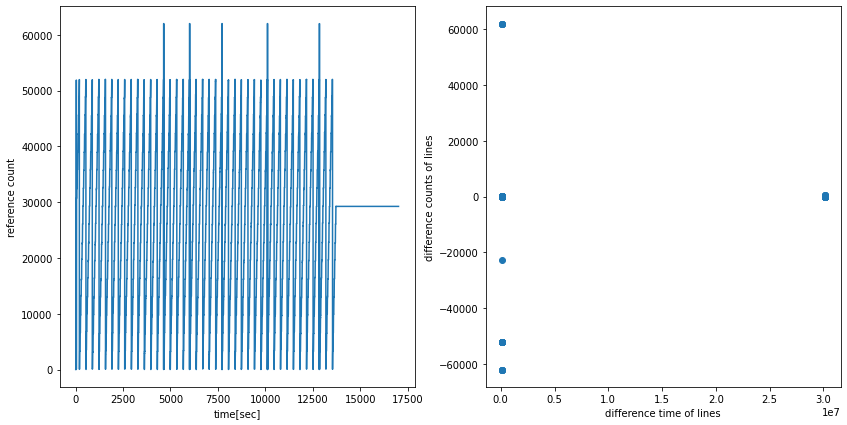

In [15]:
#first scketch of the rawdata
fig01, axarr01 = plt.subplots(1,2,figsize=(14,7))
ax01 = axarr01.ravel()

ax01[0].plot(time[::100], reference0[::100])
ax01[0].set_xlabel('time[sec]')
ax01[0].set_ylabel('reference count')

ax01[1].scatter(np.diff(timercount0), np.diff(reference0))
ax01[1].set_xlabel('difference time of lines')
ax01[1].set_ylabel('difference counts of lines')

In [16]:
error_UnixTime = np.array(time_category0[np.where((np.diff(timercount0) > 110000) | (np.diff(timercount0) < 90000))[0]], dtype=int)

error_Time = time[:-1][(np.diff(timercount0) > 110000) | (np.diff(timercount0) < 90000)]
error_TimeDelta = np.diff(time)[(np.diff(timercount0) > 110000) | (np.diff(timercount0) < 90000)]

In [17]:
for i in range(len(error_Time)):
    print('{:8.2f} {:5.4f}'.format(round(error_Time[i],2), round(error_TimeDelta[i],5)))

   60.90 0.1505
  245.26 0.1505
  552.47 0.1505
  859.68 0.1505
 1013.29 0.1505
 1351.25 0.1505
 1504.86 0.1505
 1627.71 0.1505
 1658.46 0.1505
 1781.32 0.1505
 1812.07 0.1505
 1934.93 0.1505
 2088.53 0.1505
 2426.49 0.1505
 2580.10 0.1505
 2733.71 0.1505
 2813.81 0.1505
 2887.31 0.1506
 3194.53 0.1505
 3225.28 0.1505
 3378.88 0.1505
 3501.74 0.1505
 3839.70 0.1505
 4331.27 0.1505
 4761.34 0.1505
 4945.69 0.1505
 5068.55 0.1505
 5099.30 0.1505
 5222.16 0.1505
 5375.76 0.1505
 5529.37 0.1505
 5560.12 0.1505
 5713.72 0.1505
 5867.33 0.1505
 6174.54 0.1505
 6205.29 0.1505
 6481.76 0.1505
 6512.51 0.1506
 6635.36 0.1505
 6973.32 0.1505
 7249.79 0.1505
 7280.54 0.1506
 7403.39 0.1505
 7618.50 0.1505
 7680.15 0.1505
 7710.90 0.1505
 7987.36 0.1505
 8018.12 0.1505
 8140.97 0.1505
 8171.72 0.1505
 8294.58 0.1505
 8325.33 0.1505
 8632.54 0.1505
 8755.40 0.1505
 8786.15 0.1505
 8909.00 0.1505
 8939.75 0.1505
 9216.51 0.1505
 9339.37 0.1505
 9370.12 0.1505
 9492.97 0.1505
 9677.33 0.1505
 9984.54

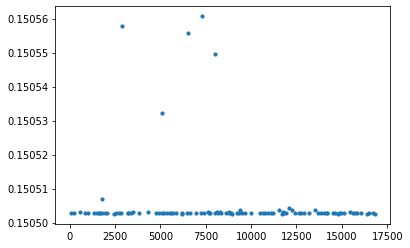

In [18]:
plt.scatter(error_Time, error_TimeDelta,s=10)

## set variables

In [19]:
capture_slice = 1000
plot_slice = 30

pos_roll = 3

casp_threshold = -100

In [20]:
#log slicing with JST
def packet_capture(dataframe, list_ampere, list_interval, UnixTime_Data):
    JST = timezone(timedelta(hours=+9), 'JST')
    initial_UnixTime = []
    switching_UnixTime = []
    start_UnixTime = []

    for i in range(iteration):
        start_UnixTime.append([])

    for i in list_ampere:
        for j in list_interval:
            list_datetime = ((dataframe[dataframe.iloc[:,5] == i])[(dataframe[dataframe.iloc[:,5] == i]).iloc[:,8] == j]).iloc[:,0:2].to_numpy()
            for k in range(iteration):
                if k%pack_size == 0:
                    start_UnixTime[int(k/pack_size)] = (((datetime.strptime(list_datetime[k][0]+' '+list_datetime[k][1],"%Y-%m-%d %H:%M:%S-%Z")).replace(tzinfo=timezone.utc)).astimezone(JST)).timestamp()
                    initial_UnixTime = np.append(initial_UnixTime, start_UnixTime[int(k/pack_size)])
                    pass
                pass
            switching_UnixTime.append(min(start_UnixTime))
            pass
        pass

    stop_UnixTime = dataframe[dataframe.iloc[:,2] == 'OFF'].iloc[-1,:]
    end_UnixTime = (((datetime.strptime(stop_UnixTime[0]+' '+stop_UnixTime[1],"%Y-%m-%d %H:%M:%S-%Z")).replace(tzinfo=timezone.utc)).astimezone(JST)).timestamp()

    captured_initials = []
    captured_switching = []
    
    for i in range(len(switching_UnixTime)):
        captured_switching.append(max(np.where(UnixTime_Data[::capture_slice] <= switching_UnixTime[i])[0]))
        pass
    
    for i in range(len(initial_UnixTime)):
        captured_initials.append(max(np.where(UnixTime_Data[::capture_slice] <= initial_UnixTime[i])[0]))
        pass
    
    captured_end = min(np.where(end_UnixTime + pos_roll <= UnixTime_Data[::capture_slice])[0])
    
    return captured_switching, captured_initials, captured_end

In [21]:
swt, inits, end = packet_capture(df, list_amp, list_intv, time_category0)

In [22]:
reference = reference0

for i in np.where(reference0 > 52000)[0]:
    reference[i] = reference0[i]-count_MAX

In [45]:
#block
time_block = []
reference_block = []

for i in range(len(swt)-1):
    time_block.append(time[int(np.where(time == (time[::capture_slice])[swt[i]-pos_roll])[0]):int(np.where(time == (time[::capture_slice])[swt[i+1]-pos_roll])[0])])
    reference_block.append(reference[int(np.where(time == (time[::capture_slice])[swt[i]-pos_roll])[0]):int(np.where(time == (time[::capture_slice])[swt[i+1]-pos_roll])[0])])
    pass
time_block.append(time[int(np.where(time == (time[::capture_slice])[swt[-1]-pos_roll])[0]):int(np.where(time == (time[::capture_slice])[end+pos_roll])[0])])
reference_block.append(reference[int(np.where(time == (time[::capture_slice])[swt[-1]-pos_roll])[0]):int(np.where(time == (time[::capture_slice])[end+pos_roll])[0])])

lincount_block = []
block_initials = []
onecycle_time = []
proceeded_degrees = []

for i in range(matrix_size):
    lincount_block.append([])
    lincount_block[i] = np.array(np.zeros(len(reference_block[i])))
    
    count_offset = 0
    casp_flag = 0
    casp = np.where(np.diff(reference_block[i]) <= casp_threshold)[0].tolist()

    for j in range(len(reference_block[i])):
        lincount_block[i][j] = reference_block[i][j]+count_offset
        if casp:
            if j == casp[casp_flag]:
                count_offset += reference_block[i][casp[casp_flag]]
                if len(casp) > casp_flag+1:
                    casp_flag += 1
                    pass
                pass
            pass
        pass
    
    block_initials.append([])
    for j in range(len(inits)):
        block_initials[i].append(int(np.where(time_block[i] == (time[::capture_slice])[(inits[i*iteration:(i+1)*iteration])[j]-pos_roll])[0]))
        pass
    
    onecycle_time.append([])
    proceeded_degrees.append([])
    for j in range(len(inits) - 1):
        if j != len(inits) - 1:
            onecycle_time[i].append(time_block[i][block_initials[i][j+1]]-time_block[i][block_initials[i][j]])
            proceeded_degrees[i].append((lincount_block[i][block_initials[i][j+1]]-lincount_block[i][block_initials[i][j]])*Deg)
            pass
        else:
            onecycle_time[i].append(time_block[i][-1]-time_block[i][block_initials[i][j]])
            proceeded_degrees[i].append((lincount_block[i][-1]-lincount_block[i][block_initials[i][j]])*Deg)
        pass
    pass

In [ ]:
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 1000:
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

### optional (not verified): mask error

In [53]:
#perepare error pack
error_pack = [[0]]
error_flag = 1
UnixInitials = np.array(time_category0[::capture_slice][inits], dtype=int)
for i in range(len(inits)):
    #print(f'{error_flag} {error_UnixTime[error_flag]} {UnixInitials[i]}')
    if (i < len(inits)-1) and (error_flag < len(error_UnixTime)-1):
        if (UnixInitials[i] <= error_UnixTime[error_flag]) and (error_UnixTime[error_flag] < UnixInitials[i+1]):
            error_pack[0].append(i)
            #print(f'{error_flag} {error_UnixTime[error_flag]}')
            error_flag += 1
            if (UnixInitials[i] <= error_UnixTime[error_flag]) and (error_UnixTime[error_flag] < UnixInitials[i+1]):
                error_flag += 1
                pass
            pass
        pass
    else:
        if (UnixInitials[i] <= error_UnixTime[error_flag]) and (error_UnixTime[error_flag] < UnixInitials[i]+min(np.diff(UnixInitials))):
            error_pack[0].append(i)
    pass

In [54]:
error_sort = []
error_sort.append([error_pack[0][0]])
for i in sorted(error_pack[0][1:]):
    error_sort[0].append(i)
#error_sort

In [55]:
#avoid error
error_position = []
error_flag0 = 0

error_flag2 = 0

for i in range(matrix_size):
    error_flag1 = 1
    error_position.append([])
    for j in range(len(inits)):
        if i == error_sort[error_flag0][0]:
            if error_flag1 <= len(error_sort[error_flag0])-1:
                if j == error_sort[error_flag0][error_flag1]:
                    #print(f'{error_sort[error_flag0][0]} {error_sort[error_flag0][error_flag1]}')
                    error_position[i].append([])
                    error_position[i][j] = False
                    error_flag1 += 1
                    error_flag2 = 1
                    pass
                else:
                    error_position[i].append([])
                    error_position[i][j] = True
                    pass
                pass
            else:
                error_position[i].append([])
                error_position[i][j] = True
                pass
            pass
        else:
            error_position[i].append([])
            error_position[i][j] = True
            pass
        pass
    if error_flag2 == 1:
        if error_flag0 != len(error_sort)-1:
            error_flag0 += 1
            error_flag2 = 0
            pass
        pass
    pass

In [56]:
#cutting more
cp0 = reference > 60000
cp1 = time[:-1][~cp0[1:] & cp0[:-1]]-10
over_flag = 0

paku = []

for i in range(matrix_size):
    for j in range(len(inits)-1):
        if error_position[i][j] != False:
            cp2 = ((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[:-1]
            #print(f'{over_flag} {round(cp1[over_flag],2)} {round(cp2[0],2)} {round(cp2[-1],2)} {round(cp2[0],2) <=  round(cp1[over_flag],2)} {round(cp1[over_flag],2) < round(cp2[-1],2)}')
            if not (cp2[0] <=  cp1[over_flag]) and (cp1[over_flag] <= cp2[-1]):
                if over_flag < len(cp1)-1:
                    over_flag += 1
                    pass
            if (cp2[0] <=  cp1[over_flag]) and (cp1[over_flag] <= cp2[-1]):
                paku.append(j)
                if over_flag < len(cp1)-1:
                    over_flag += 1
                    pass
                pass
            pass
        pass
    pass

IndexError: index 0 is out of bounds for axis 0 with size 0

In [38]:
for i in paku:
    error_pack[0].append(i)

In [31]:
#avoid error
error_position = []
error_flag0 = 0

error_flag2 = 0

for i in range(matrix_size):
    error_flag1 = 1
    error_position.append([])
    for j in range(len(inits)):
        if i == error_sort[error_flag0][0]:
            if error_flag1 <= len(error_sort[error_flag0])-1:
                if j == error_sort[error_flag0][error_flag1]:
                    #print(f'{error_sort[error_flag0][0]} {error_sort[error_flag0][error_flag1]}')
                    error_position[i].append([])
                    error_position[i][j] = False
                    error_flag1 += 1
                    error_flag2 = 1
                    pass
                else:
                    error_position[i].append([])
                    error_position[i][j] = True
                    pass
                pass
            else:
                error_position[i].append([])
                error_position[i][j] = True
                pass
            pass
        else:
            error_position[i].append([])
            error_position[i][j] = True
            pass
        pass
    if error_flag2 == 1:
        if error_flag0 != len(error_sort)-1:
            error_flag0 += 1
            error_flag2 = 0
            pass
        pass
    pass

# Plots

(-1.0, 4.0)

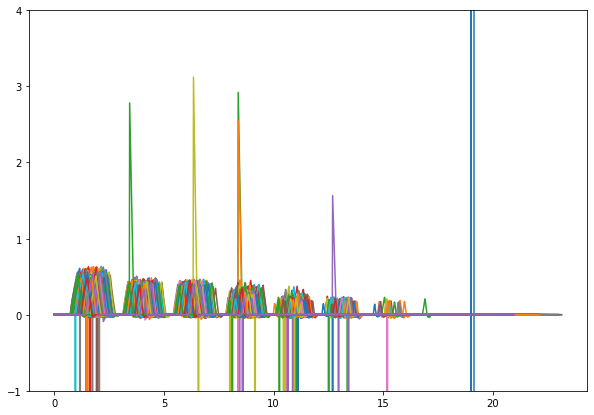

In [58]:
# so called speed
fig10 = plt.figure(figsize=(10,7))

cut_place = []

for i in range(matrix_size):
    cut_place.append([])
    for j in range(len(inits)-5):
        cut_place[i].append([])
        #if error_position[i][j] != False:
        cut_threshold = ((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[:-1]-time_block[i][block_initials[i][j]]
        cut_place[i][j] = min(np.where(cut_threshold >= 19)[0])
        plt.axvline(cut_threshold[cut_place[i][j]])
        plt.plot(((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[:-1]-time_block[i][block_initials[i][j]],
                    np.diff((reference_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])*Deg,label=f'num_{j}')
        #pass
        pass
    pass
plt.ylim([-1,4])

In [63]:
x1 = np.arange(0,360,22.5)
x2 = np.roll(x1, 6)
x3 = np.tile(x2, 40)

In [64]:
goal = end_position[0]

for i in np.where(np.array(end_position[0]) > 350)[0]:
    x3[i] = 360

In [65]:
def linear_func(x,a,b):
    return a*x+b

In [66]:
popt, pcov = curve_fit(linear_func, x3[:-1], goal)
popt

ValueError: `ydata` must not be empty!

## sub

In [ ]:
fig11, ax11 = plt.subplots(1,1,figsize=(300,7))

for i in range(matrix_size):
    for j in range(len(inits)-1):
        #if error_position[i][j] != False:
        ax11.plot(((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[:-1],
                        np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice]),label=f'num_{j}')
            #pass
        pass
    pass

for i in range(len(error_Time)):
    ax11.axvline(error_Time[i], ls=':', lw=3)
    pass

fuga = reference > 60000
ax11.scatter((time[:-1])[~fuga[1:] & fuga[:-1]]-10, np.ones(len((time[:-1])[~fuga[1:] & fuga[:-1]]))*100)

ax11.set_ylim([-1,200])
#ax11.xlim([700,770])

ax11.xaxis.set_major_locator(tik.MultipleLocator(100))

ax11.set_title(f'Jan13_absolute_feedback_5times')
ax11.set_xlabel('time[sec]')
ax11.set_ylabel('difference of counts')

# Input data and log

In [12]:
def packet_capture(dataframe, list_ampere, list_interval, UnixTime_Data):
    JST = timezone(timedelta(hours=+9), 'JST')
    initial_UnixTime = []
    switching_UnixTime = []
    start_UnixTime = []

    for i in range(iteration):
        start_UnixTime.append([])

    for i in list_ampere:
        for j in list_interval:
            list_datetime = ((dataframe[dataframe.iloc[:,5] == i])[(dataframe[dataframe.iloc[:,5] == i]).iloc[:,8] == j]).iloc[:,0:2].to_numpy()
            for k in range(iteration):
                if k%pack_size == 0:
                    start_UnixTime[int(k/pack_size)] = (((datetime.strptime(list_datetime[k][0]+' '+list_datetime[k][1],"%Y-%m-%d %H:%M:%S-%Z")).replace(tzinfo=timezone.utc)).astimezone(JST)).timestamp()
                    initial_UnixTime = np.append(initial_UnixTime, start_UnixTime[int(k/pack_size)])
                    pass
                pass
            switching_UnixTime.append(min(start_UnixTime))
            pass
        pass

    stop_UnixTime = dataframe[dataframe.iloc[:,2] == 'OFF'].iloc[-1,:]
    end_UnixTime = (((datetime.strptime(stop_UnixTime[0]+' '+stop_UnixTime[1],"%Y-%m-%d %H:%M:%S-%Z")).replace(tzinfo=timezone.utc)).astimezone(JST)).timestamp()

    captured_initials = []
    captured_switching = []
    
    for i in range(len(switching_UnixTime)):
        captured_switching.append(max(np.where(time_category[::capture_slice] <= switching_UnixTime[i])[0]))
        pass
    
    for i in range(len(initial_UnixTime)):
        captured_initials.append(max(np.where(time_category[::capture_slice] <= initial_UnixTime[i])[0]))
        pass
    
    captured_end = min(np.where(end_UnixTime + pos_roll <= time_category[::capture_slice])[0])
    
    return captured_switching, captured_initials, captured_end

In [13]:
swt, inits, end = packet_capture(df, list_amp, list_intv, time_category)

In [84]:
reference

array([1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 2.9234e+04, 2.9234e+04,
       2.9234e+04])

In [80]:
len(reference)

33971700

In [83]:
len(reference[np.where(reference > 52000)[0]])

129382

In [81]:
len(reference[reference > 52000])

129382

In [19]:
reference1 = reference

hoge = np.where(reference > 52000)[0]

for i in hoge:
    reference1[i] = reference[i]-62000

In [46]:
reference1

array([1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 2.9234e+04, 2.9234e+04,
       2.9234e+04])

In [20]:
#block
time_block = []
reference_block = []

for i in range(len(swt)-1):
    time_block.append(time[int(np.where(time == (time[::capture_slice])[swt[i]-pos_roll])[0]):int(np.where(time == (time[::capture_slice])[swt[i+1]-pos_roll])[0])])
    reference_block.append(reference1[int(np.where(time == (time[::capture_slice])[swt[i]-pos_roll])[0]):int(np.where(time == (time[::capture_slice])[swt[i+1]-pos_roll])[0])])
    pass
time_block.append(time[int(np.where(time == (time[::capture_slice])[swt[-1]-pos_roll])[0]):int(np.where(time == (time[::capture_slice])[end+pos_roll])[0])])
reference_block.append(reference1[int(np.where(time == (time[::capture_slice])[swt[-1]-pos_roll])[0]):int(np.where(time == (time[::capture_slice])[end+pos_roll])[0])])

lincount_block = []
block_initials = []
onecycle_time = []
proceeded_degrees = []

for i in range(matrix_size):
    lincount_block.append([])
    lincount_block[i] = np.array(np.zeros(len(reference_block[i])))
    
    count_offset = 0
    casp_flag = 0
    casp = np.where(np.diff(reference_block[i]) <= casp_threshold)[0].tolist()

    for j in range(len(reference_block[i])):
        lincount_block[i][j] = reference_block[i][j]+count_offset
        if casp:
            if j == casp[casp_flag]:
                count_offset += reference_block[i][casp[casp_flag]]
                if len(casp) > casp_flag+1:
                    casp_flag += 1
                    pass
                pass
            pass
        pass
    
    block_initials.append([])
    for j in range(len(inits)):
        block_initials[i].append(int(np.where(time_block[i] == (time[::capture_slice])[(inits[i*iteration:(i+1)*iteration])[j]-pos_roll])[0]))
        pass
    
    onecycle_time.append([])
    proceeded_degrees.append([])
    for j in range(len(inits) - 1):
        if j != len(inits) - 1:
            onecycle_time[i].append(time_block[i][block_initials[i][j+1]]-time_block[i][block_initials[i][j]])
            proceeded_degrees[i].append((lincount_block[i][block_initials[i][j+1]]-lincount_block[i][block_initials[i][j]])*Deg)
            pass
        else:
            onecycle_time[i].append(time_block[i][-1]-time_block[i][block_initials[i][j]])
            proceeded_degrees[i].append((lincount_block[i][-1]-lincount_block[i][block_initials[i][j]])*Deg)
        pass
    pass

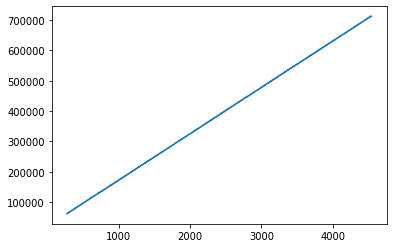

In [50]:
i = 0
j = 10
k = 200

t1 = ((time_block[i][block_initials[i][j]:block_initials[i][j+k]])[::10])
t2 = (lincount_block[i][block_initials[i][j]:block_initials[i][j+k]])[::10]
t3 = (reference_block[i][block_initials[i][j]:block_initials[i][j+k]])[::10]

plt.plot(t1, t2)

# for l in range(len(time[casp])):
#     plt.axvline(time[casp][l],color='r')
#     pass

#plt.xlim([4638,4642])
#plt.xlim([4500,4700])

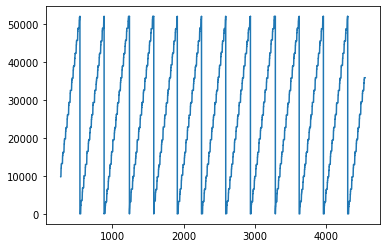

In [51]:
plt.plot(t1,t3)

In [44]:
reference[reference > 52000]-62000

array([-1., -1., -1., ..., -2., -1., -1.])

In [ ]:
np.diff(reference_block[0])

In [118]:
time[casp]

array([  147.97814025,   490.43630612,   829.25255326,  1184.9828123 ,
        1525.87878198,  1856.02611176,  2195.40359756,  2534.96209722,
        2881.37474033,  3231.09225871,  3565.37289462,  3904.87532943,
        4245.88468221,  4586.18611121,  4597.98178134,  4929.89313534,
        5280.48677154,  5623.00628325,  5950.16612903,  5964.05386242,
        6292.85517668,  6647.41384652,  6988.25523571,  7329.0126864 ,
        7655.22253359,  7670.94180511,  8001.51161675,  8354.05027501,
        8679.93297645,  9024.7315923 ,  9365.93910228,  9708.03070513,
       10051.70576649, 10063.64192234, 10405.65147116, 10735.03979611,
       11088.70594961, 11417.43224736, 11759.34273398, 12114.43392128,
       12457.42444765, 12786.56933897, 12798.47949667, 13131.18101097,
       13482.40654701])

In [21]:
error_pack = [[0]]
error_flag = 1
UnixInitials = np.array(time_category[::capture_slice][inits], dtype=int)
for i in range(len(inits)):
    #print(f'{error_flag} {error_UnixTime[error_flag]} {UnixInitials[i]}')
    if (i < len(inits)-1) and (error_flag < len(error_UnixTime)-1):
        if (UnixInitials[i] <= error_UnixTime[error_flag]) and (error_UnixTime[error_flag] < UnixInitials[i+1]):
            error_pack[0].append(i)
            #print(f'{error_flag} {error_UnixTime[error_flag]}')
            error_flag += 1
            if (UnixInitials[i] <= error_UnixTime[error_flag]) and (error_UnixTime[error_flag] < UnixInitials[i+1]):
                error_flag += 1
                pass
            pass
        pass
    else:
        if (UnixInitials[i] <= error_UnixTime[error_flag]) and (error_UnixTime[error_flag] < UnixInitials[i]+min(np.diff(UnixInitials))):
            error_pack[0].append(i)
    pass

In [17]:
len(error_pack[0])

87

In [37]:
for i in paku:
    error_pack[0].append(i)

In [105]:
paku = []

In [22]:
error_sort = []
error_sort.append([error_pack[0][0]])
for i in sorted(error_pack[0][1:]):
    error_sort[0].append(i)
#error_sort

In [50]:
len(error_sort[0])

114

In [23]:
#avoid error
error_position = []
error_flag0 = 0

error_flag2 = 0

for i in range(matrix_size):
    error_flag1 = 1
    error_position.append([])
    for j in range(len(inits)):
        if i == error_sort[error_flag0][0]:
            if error_flag1 <= len(error_sort[error_flag0])-1:
                if j == error_sort[error_flag0][error_flag1]:
                    #print(f'{error_sort[error_flag0][0]} {error_sort[error_flag0][error_flag1]}')
                    error_position[i].append([])
                    error_position[i][j] = False
                    error_flag1 += 1
                    error_flag2 = 1
                    pass
                else:
                    error_position[i].append([])
                    error_position[i][j] = True
                    pass
                pass
            else:
                error_position[i].append([])
                error_position[i][j] = True
                pass
            pass
        else:
            error_position[i].append([])
            error_position[i][j] = True
            pass
        pass
    if error_flag2 == 1:
        if error_flag0 != len(error_sort)-1:
            error_flag0 += 1
            error_flag2 = 0
            pass
        pass
    pass

In [129]:
error_position[0][288]

False

In [27]:
for i in range(matrix_size):
    print(f'{len(time_block[i])} {len(reference_block[i])}')

1601000 1601000
1602000 1602000
1601000 1601000
1602000 1602000
1602000 1602000
1603000 1603000
1602000 1602000
1602000 1602000
1601000 1601000
1604000 1604000
1601000 1601000
1602000 1602000
1604000 1604000
1601000 1601000
1601000 1601000
1602000 1602000
1604000 1604000
1601000 1601000
1601000 1601000
1608000 1608000
1616000 1616000
1601000 1601000
1604000 1604000
1625000 1625000
1630000 1630000
1623000 1623000
1628000 1628000
1655000 1655000
1658000 1658000
1654000 1654000


In [335]:
len(inits)-len(error_sort[0])

327

In [25]:
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 1000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|             UnixInitials|      5216|
|                       df|   6078030|
|                    inits|      5496|
|                     time| 271773696|


In [26]:
del df

(-1.0, 4.0)

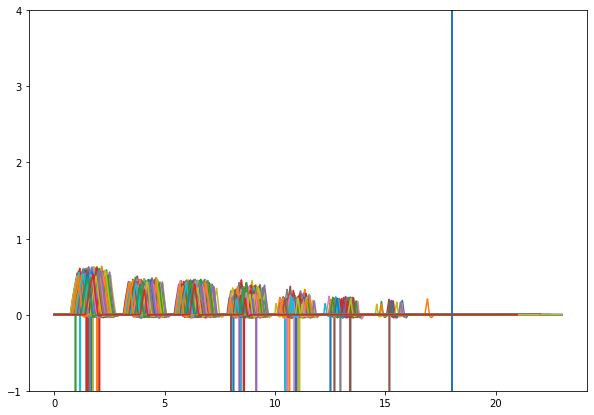

In [24]:
fig10 = plt.figure(figsize=(10,7))

fuga = []

for i in range(matrix_size):
    fuga.append([])
    for j in range(len(inits)-5):
        fuga[i].append([])
        if error_position[i][j] != False:
            hoge = ((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[:-1]-time_block[i][block_initials[i][j]]
            fuga[i][j] = min(np.where(hoge >= 18)[0])
            plt.axvline(hoge[fuga[i][j]])
            plt.plot(((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[:-1]-time_block[i][block_initials[i][j]],
                        np.diff((reference_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])*Deg,label=f'num_{j}')
            pass
        pass
    pass
plt.ylim([-1,4])

Text(0, 0.5, 'difference of counts')

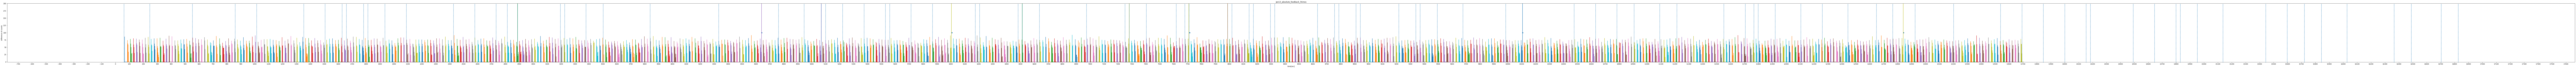

In [84]:
fig11, ax11 = plt.subplots(1,1,figsize=(300,7))

for i in range(matrix_size):
    for j in range(len(inits)-1):
        #if error_position[i][j] != False:
        ax11.plot(((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[:-1],
                        np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice]),label=f'num_{j}')
            #pass
        pass
    pass

for i in range(len(error_Time)):
    ax11.axvline(error_Time[i], ls=':', lw=3)
    pass

fuga = reference > 60000
ax11.scatter((time[:-1])[~fuga[1:] & fuga[:-1]]-10, np.ones(len((time[:-1])[~fuga[1:] & fuga[:-1]]))*100)

ax11.set_ylim([-1,200])
#ax11.xlim([700,770])

ax11.xaxis.set_major_locator(tik.MultipleLocator(100))

ax11.set_title(f'Jan13_absolute_feedback_5times')
ax11.set_xlabel('time[sec]')
ax11.set_ylabel('difference of counts')

In [336]:
fig11.savefig(storepath + storename + '_DiffPlots.png')

In [25]:
cp0 = reference > 60000
cp1 = time[:-1][~cp0[1:] & cp0[:-1]]-10
over_flag = 0

paku = []

for i in range(matrix_size):
    for j in range(len(inits)-1):
        if error_position[i][j] != False:
            cp2 = ((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[:-1]
            #print(f'{over_flag} {round(cp1[over_flag],2)} {round(cp2[0],2)} {round(cp2[-1],2)} {round(cp2[0],2) <=  round(cp1[over_flag],2)} {round(cp1[over_flag],2) < round(cp2[-1],2)}')
            if not (cp2[0] <=  cp1[over_flag]) and (cp1[over_flag] <= cp2[-1]):
                if over_flag < len(cp1)-1:
                    over_flag += 1
                    pass
            if (cp2[0] <=  cp1[over_flag]) and (cp1[over_flag] <= cp2[-1]):
                paku.append(j)
                if over_flag < len(cp1)-1:
                    over_flag += 1
                    pass
                pass
            pass
        pass
    pass

IndexError: index 0 is out of bounds for axis 0 with size 0

In [36]:
paku

[214, 278, 470, 598]

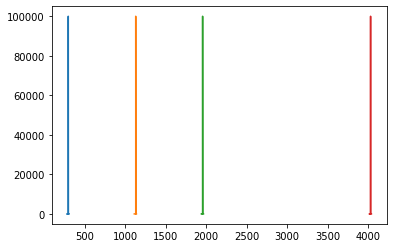

In [48]:
for i in range(matrix_size):
    for j in paku:
        if error_position[i][j] != False:
            plt.plot(((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[:-1],
                        np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice]),label=f'num_{j}')
            pass
        pass
    pass

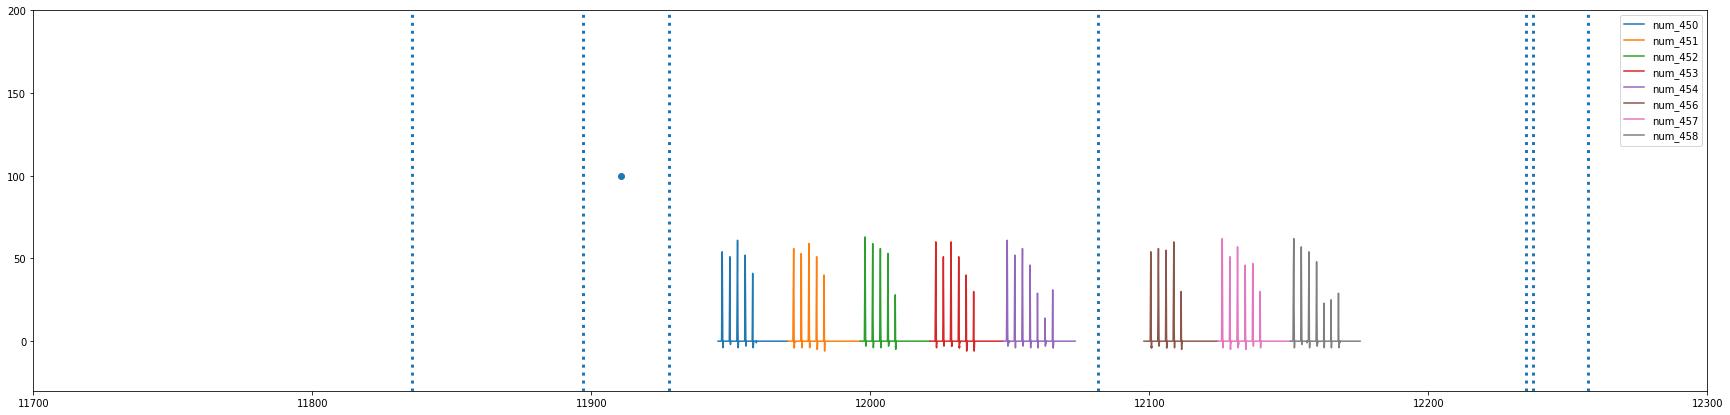

In [136]:
fig15 = plt.figure(figsize=(30,7))

for i in range(matrix_size):
    for j in range(450,459):
        if error_position[i][j] != False:
            plt.plot(((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[:-1],
                        np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice]),label=f'num_{j}')
            pass
        pass
    pass

for i in range(60,70):
    plt.axvline(error_Time[i], ls=':', lw=3)
    pass

fuga = reference > 60000
peke = (time[:-1])[~fuga[1:] & fuga[:-1]]
plt.scatter(peke-10, np.ones(len(peke))*100)

plt.xlim([11700,12300])
plt.ylim([-30,200])
plt.legend()

NameError: name 'error_position' is not defined

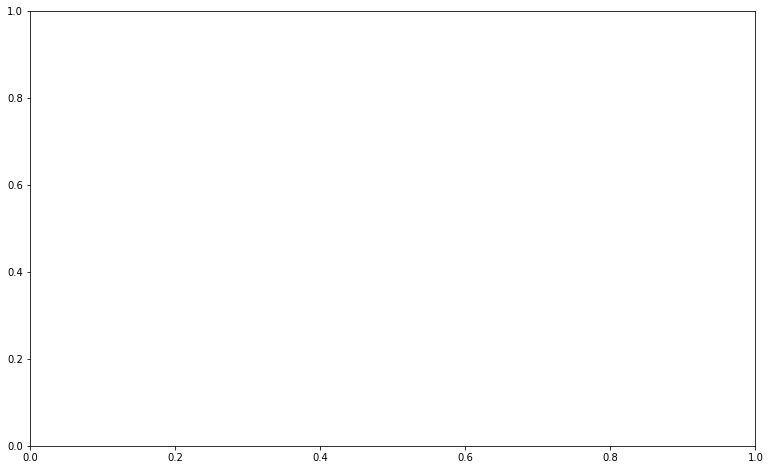

In [21]:
moved_angle = []
end_position = []

fig20, ax = plt.subplots(figsize=(13,8))
#ax = axarr.ravel()

for i in range(matrix_size):
    moved_angle.append([])
    end_position.append([])
    for j in range(iteration-1):
        if error_position[i][j] != False:
            hoge = (time_block[i][block_initials[i][j]:block_initials[i][j+1]])-time_block[i][block_initials[i][j]]
            place = min(np.where(hoge >= 20)[0])
            moved_angle[i].append((reference_block[i][block_initials[i][j] + place]-reference_block[i][block_initials[i][j]])*Deg)
            end_position[i].append(reference_block[i][block_initials[i][j] + place]%52000*Deg)
        pass
        pass
    ax.scatter(end_position[i], moved_angle[i], color='b')
    pass

for i in range(len(np.arange(0,382.5,22.5))):
    ax.axvline(np.arange(0,382.5,22.5)[i], ls=':', color='r')
    pass

#plt.ylim([0,50])

ax.xaxis.set_major_locator(tik.MultipleLocator(22.5))

ax.set_title(f'Jan18_absolute_feedback_8times')
ax.set_xlabel('position[deg]')
ax.set_ylabel('proceeded degree')

In [180]:
fig20.savefig(storepath + storename + '_POSvsDeg.png', facecolor='white')

NameError: name 'lincount_block' is not defined

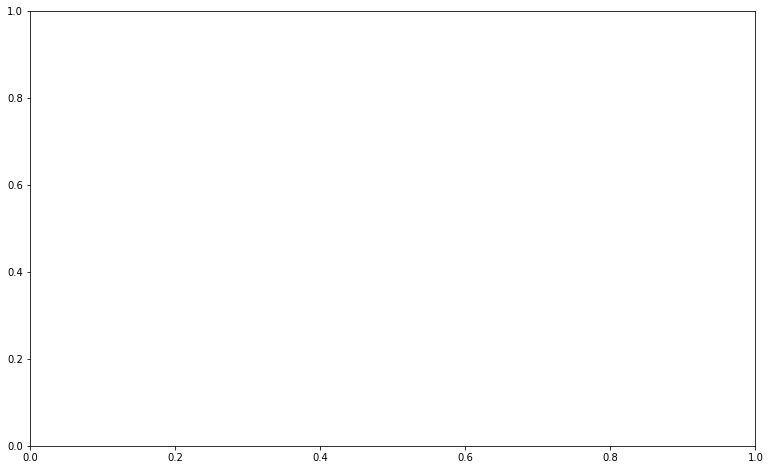

In [44]:
moved_angle = []
end_position = []

fig21, ax = plt.subplots(figsize=(13,8))
#ax = axarr.ravel()

for i in range(matrix_size):
    moved_angle.append([])
    end_position.append([])
    for j in range(iteration-1):
        #if error_position[i][j] != False:
        hoge = (time_block[i][block_initials[i][j]:block_initials[i][j+1]])-time_block[i][block_initials[i][j]]
        place = min(np.where(hoge >= 20)[0])
        moved_angle[i].append((lincount_block[i][block_initials[i][j] + place]-lincount_block[i][block_initials[i][j]])*Deg)
        end_position[i].append(lincount_block[i][block_initials[i][j] + place]%52000*Deg)
        #pass
        pass
    ax.scatter(end_position[i], moved_angle[i], color='b')
    pass

for i in range(len(np.arange(0,382.5,22.5))):
    ax.axvline(np.arange(0,382.5,22.5)[i], ls=':', color='r')
    pass

#plt.ylim([10,30])

ax.xaxis.set_major_locator(tik.MultipleLocator(45))

ax.set_title(f'Jan19_absolute2_feedback_8times')
ax.set_xlabel('position[deg]')
ax.set_ylabel('proceeded degree')

In [85]:
fig21.savefig(storepath + storename + '_POSvsDeg.png', facecolor='white')

In [ ]:
np.arange()

(array([21.,  0., 37.,  3.,  0., 40.,  0.,  0., 45.,  0.,  0., 40.,  0.,
         0., 40.,  0., 33.,  7.,  0., 40.,  0.,  0., 40.,  0.,  0., 39.,
         0.,  0., 40.,  0., 25., 15.,  0., 40.,  0.,  0., 40.,  0.,  0.,
        40.,  0.,  0., 40.,  0., 14.]),
 array([1.38461538e-02, 8.01061538e+00, 1.60073846e+01, 2.40041538e+01,
        3.20009231e+01, 3.99976923e+01, 4.79944615e+01, 5.59912308e+01,
        6.39880000e+01, 7.19847692e+01, 7.99815385e+01, 8.79783077e+01,
        9.59750769e+01, 1.03971846e+02, 1.11968615e+02, 1.19965385e+02,
        1.27962154e+02, 1.35958923e+02, 1.43955692e+02, 1.51952462e+02,
        1.59949231e+02, 1.67946000e+02, 1.75942769e+02, 1.83939538e+02,
        1.91936308e+02, 1.99933077e+02, 2.07929846e+02, 2.15926615e+02,
        2.23923385e+02, 2.31920154e+02, 2.39916923e+02, 2.47913692e+02,
        2.55910462e+02, 2.63907231e+02, 2.71904000e+02, 2.79900769e+02,
        2.87897538e+02, 2.95894308e+02, 3.03891077e+02, 3.11887846e+02,
        3.19884615e+0

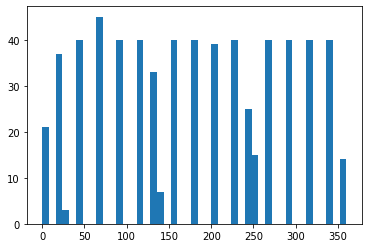

In [54]:
plt.hist(end_position,bins=45)

In [58]:
absolute_position = np.arange(0,360,22.5)

In [85]:
x1 = np.arange(0,360,22.5)
x2 = np.roll(x1, 6)
x3 = np.tile(x2, 40)

In [68]:
goal = end_position[0]

hoge = np.where(np.array(end_position[0]) > 350)[0]

for i in hoge:
    x3[i] = 360

In [ ]:
len(x3)

In [ ]:
len(goal)

ValueError: x and y must be the same size

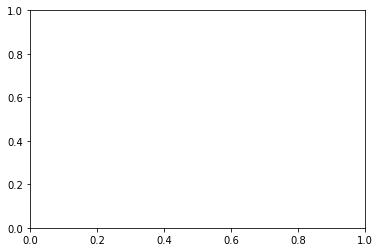

In [69]:
plt.scatter(x3[:-1], goal)

In [90]:
def linear_func(x,a,b):
    return a*x+b

popt, pcov = curve_fit(linear_func, x3[:-1], goal)
popt

In [91]:
popt, pcov = curve_fit(linear_func, x3[:-1], goal)
popt

array([0.99955516, 0.30294094])

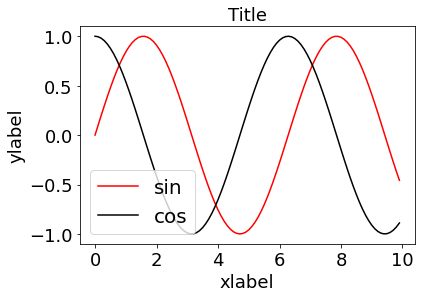

In [120]:
x = np.arange(0, 10, 0.1)
s = np.sin(x)
c = np.cos(x)

plt.plot(x, s, "r", label="sin")
plt.plot(x, c, "k", label="cos")
plt.title("Title", fontsize=18)
plt.xlabel("xlabel", fontsize=18)
plt.ylabel("ylabel", fontsize=18)
plt.legend(fontsize=20)
plt.tick_params(labelsize=18)

No handles with labels found to put in legend.


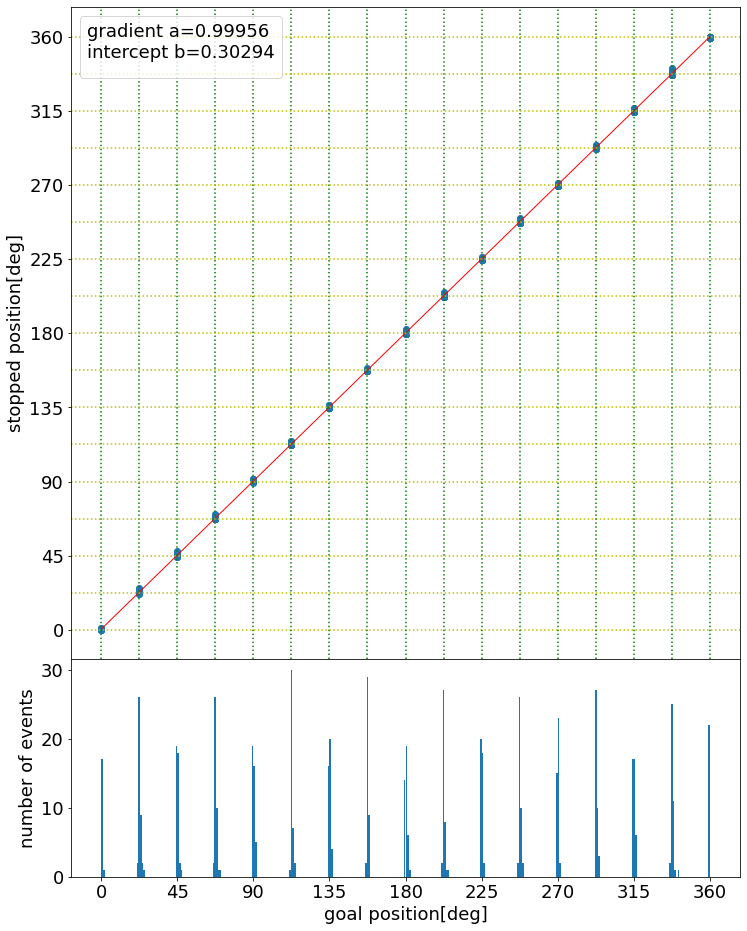

In [134]:
figX, axarr = plt.subplots(2,1,figsize=(12,16), gridspec_kw={'height_ratios':[3,1]})
plt.rcParams["font.size"] = 18
ax = axarr.ravel()
plt.subplots_adjust(hspace=0.)

piyo = np.linspace(0,360,len(x3[:-1]))

ax[0].scatter(x3[:-1], goal)
ax[0].plot(piyo, linear_func(piyo, popt[0], popt[1]),color='r', lw=1)

hoge = np.arange(0,382.5,22.5)
for i in range(len(hoge)):
    ax[0].axvline(hoge[i], ls=':', color='g')
    ax[0].axhline(hoge[i], ls=':', color='y')

#ax[0].set_xlabel('goal_position[deg]', fontsize=15)
ax[0].set_ylabel('stopped position[deg]')
ax[0].yaxis.set_major_locator(tik.MultipleLocator(45))
ax[0].legend(loc='upper left', title=f'gradient a={round(popt[0],5)}\nintercept b={round(popt[1],5)}')

ax[1].hist(goal, bins=360)
ax[1].set_xlabel('goal position[deg]')
ax[1].set_ylabel('number of events')
ax[1].xaxis.set_major_locator(tik.MultipleLocator(45))

In [135]:
figX.savefig(storepath + storename + '_PosAccuracy1.png', facecolor='white')

No handles with labels found to put in legend.


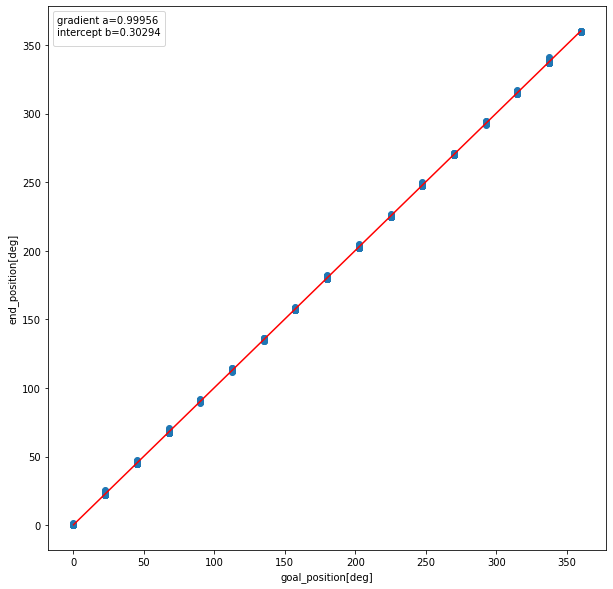

In [108]:
figXX, axarr = plt.subplots(figsize=(10,10))

piyo = np.linspace(0,360,len(x3[:-1]))

plt.scatter(x3[:-1], goal)
plt.plot(piyo, linear_func(piyo, popt[0], popt[1]),color='r')

plt.xlabel('goal_position[deg]')
plt.ylabel('end_position[deg]')

plt.legend(loc='upper left',fontsize=10,title=f'gradient a={round(popt[0],5)}\nintercept b={round(popt[1],5)}')

Text(0, 0.5, 'difference between goal and end position[deg]')

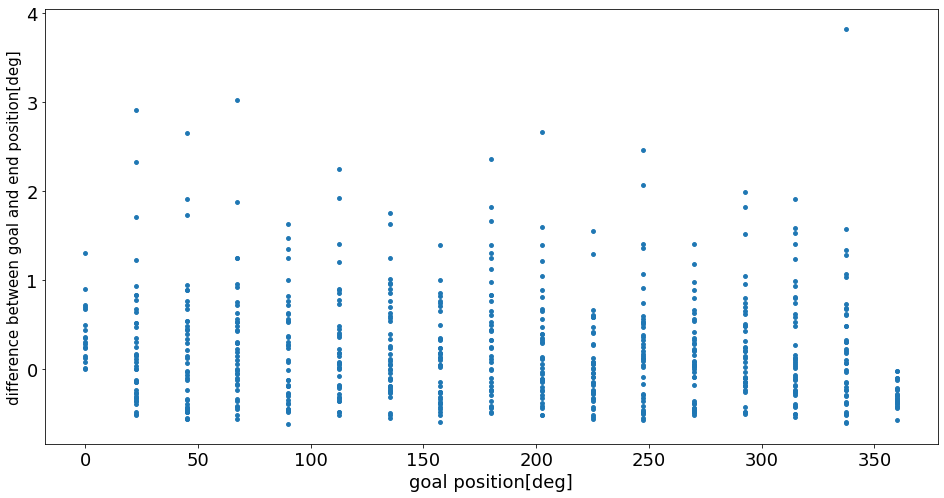

In [130]:
figY = plt.figure(figsize=(16,8))
plt.rcParams["font.size"] = 18

plt.scatter(x3[:-1], goal-x3[:-1], s=15)
plt.xlabel('goal position[deg]')
plt.ylabel('difference between goal and end position[deg]', fontsize=15)

In [131]:
figY.savefig(storepath + storename + '_PosAccuracy2.png', facecolor='white')

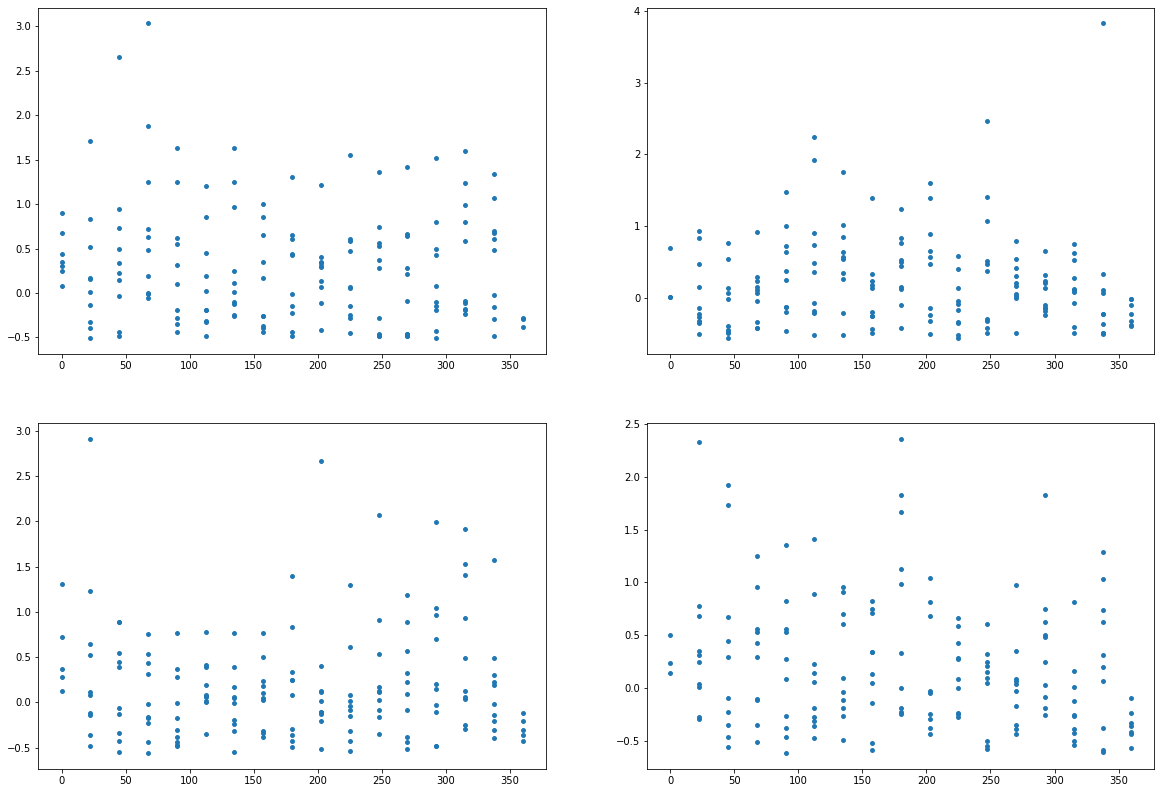

In [116]:
figYY, axarr = plt.subplots(2,2,figsize=(20,14))
ax = axarr.ravel()

d0 = 4
piko = int(iteration/d0)

for i in range(d0):
    ax[i].scatter((x3[:-1])[piko*i:piko*(i+1)], (goal-x3[:-1])[piko*i:piko*(i+1)],s=15)
    pass

In [117]:
figYY.savefig(storepath + storename + '_PosAccuracy3.png', facecolor='white')

In [26]:
iteration/16

40.0

In [75]:
np.array(end_position[0])

array([2.24550000e+02, 2.48033077e+02, 2.70664615e+02, 2.92354615e+02,
       3.15803077e+02, 3.38109231e+02, 4.43076923e-01, 2.26800000e+01,
       4.53461538e+01, 6.77007692e+01, 9.16407692e+01, 1.12181538e+02,
       1.36640769e+02, 1.57250769e+02, 1.80657692e+02, 2.02908462e+02,
       2.24861538e+02, 2.47029231e+02, 2.69550000e+02, 2.92320000e+02,
       3.15996923e+02, 3.38199231e+02, 9.69230769e-02, 2.42238462e+01,
       4.76653846e+01, 6.93969231e+01, 9.01176923e+01, 1.13718462e+02,
       1.35256154e+02, 1.57680000e+02, 1.80623077e+02, 2.02818462e+02,
       2.25076154e+02, 2.48254615e+02, 2.69923846e+02, 2.92410000e+02,
       3.14826923e+02, 3.38185385e+02, 9.20769231e-01, 2.21261538e+01,
       4.45846154e+01, 6.80053846e+01, 9.03323077e+01, 1.13372308e+02,
       1.34923846e+02, 1.57866923e+02, 1.81329231e+02, 2.02659231e+02,
       2.24743846e+02, 2.47887692e+02, 2.69543077e+02, 2.92098462e+02,
       3.16260000e+02, 3.38005385e+02, 3.59640000e+02, 2.21953846e+01,
      

In [42]:
len(np.array(end_position[0]))

639

In [43]:
position_log[1:]

array([2.24550e+02, 2.48033e+02, 2.70665e+02, 2.92355e+02, 3.15803e+02,
       3.38109e+02, 4.43000e-01, 2.26800e+01, 4.53460e+01, 6.77010e+01,
       9.16410e+01, 1.12182e+02, 1.36641e+02, 1.57251e+02, 1.80658e+02,
       2.02908e+02, 2.24862e+02, 2.47029e+02, 2.69550e+02, 2.92320e+02,
       3.15997e+02, 3.38199e+02, 9.70000e-02, 2.42240e+01, 4.76650e+01,
       6.93970e+01, 9.01180e+01, 1.13718e+02, 1.35256e+02, 1.57673e+02,
       1.80623e+02, 2.02818e+02, 2.25076e+02, 2.48255e+02, 2.69924e+02,
       2.92410e+02, 3.14827e+02, 3.38185e+02, 9.21000e-01, 2.21260e+01,
       4.45850e+01, 6.80050e+01, 9.03320e+01, 1.13372e+02, 1.34924e+02,
       1.57867e+02, 1.81329e+02, 2.02659e+02, 2.24744e+02, 2.47888e+02,
       2.69543e+02, 2.92098e+02, 3.16260e+02, 3.38005e+02, 3.59640e+02,
       2.21950e+01, 4.49860e+01, 6.82410e+01, 8.97370e+01, 1.12334e+02,
       1.34765e+02, 1.57078e+02, 1.80007e+02, 2.02874e+02, 2.25498e+02,
       2.47237e+02, 2.70305e+02, 2.92604e+02, 3.14785e+02, 3.370

In [44]:
len(position_log[1:])

639

In [88]:
62000/52000*360

429.2307692307692

In [55]:
for i in range(len(position_log[1:])):
    print(f'{i} {np.array(round(end_position[0][i],3))} {position_log[1:][i]} {x3[:-1][i]}')

0 224.55 224.55 225.0
1 248.033 248.033 247.5
2 270.665 270.665 270.0
3 292.355 292.355 292.5
4 315.803 315.803 315.0
5 338.109 338.109 337.5
6 0.436 0.443 0.0
7 22.673 22.68 22.5
8 45.339 45.346 45.0
9 67.694 67.701 67.5
10 91.634 91.641 90.0
11 112.175 112.182 112.5
12 136.634 136.641 135.0
13 157.244 157.251 157.5
14 180.651 180.658 180.0
15 202.902 202.908 202.5
16 224.855 224.862 225.0
17 247.022 247.029 247.5
18 269.543 269.55 270.0
19 292.313 292.32 292.5
20 315.99 315.997 315.0
21 338.192 338.199 337.5
22 0.083 0.097 0.0
23 24.21 24.224 22.5
24 47.652 47.665 45.0
25 69.383 69.397 67.5
26 90.104 90.118 90.0
27 113.705 113.718 112.5
28 135.242 135.256 135.0
29 157.666 157.673 157.5
30 180.609 180.623 180.0
31 202.805 202.818 202.5
32 225.062 225.076 225.0
33 248.241 248.255 247.5
34 269.91 269.924 270.0
35 292.396 292.41 292.5
36 314.813 314.827 315.0
37 338.172 338.185 337.5
38 0.9 0.921 0.0
39 22.105 22.126 22.5
40 44.564 44.585 45.0
41 67.985 68.005 67.5
42 90.312 90.332 90.0


In [77]:
np.where(position_log[1:] > 360)[0]

array([214, 278, 358, 470, 598])

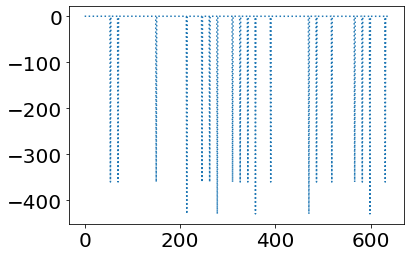

In [135]:
plt.plot(goal - position_log[1:], ls=':')

In [134]:
hoge = reference[(720 < time) & (time < 770)]
hoge

array([50428., 50430., 50432., ...,  3249.,  3249.,  3249.])

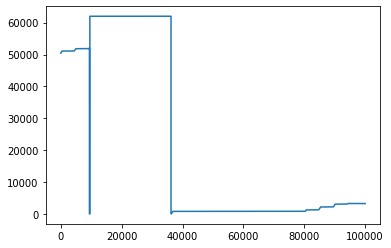

In [135]:
plt.plot(hoge)

Text(0, 0.5, 'proceeded degree')

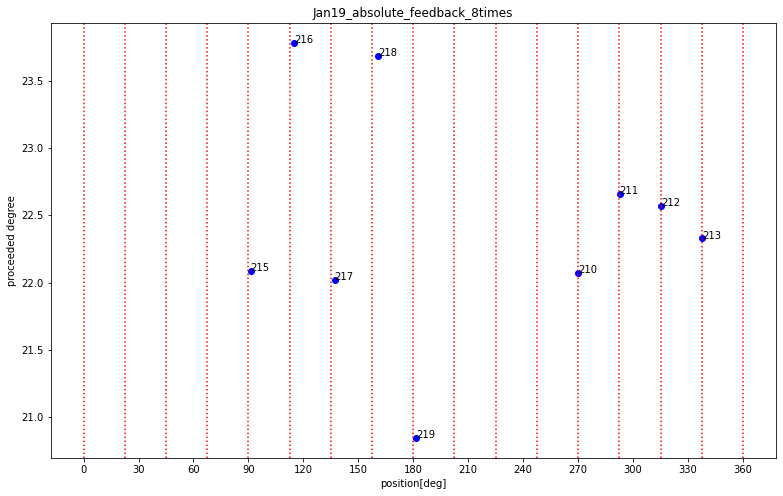

In [75]:
moved_angle = []
end_position = []
peko = []

fig21, ax = plt.subplots(figsize=(13,8))
#ax = axarr.ravel()

for i in range(matrix_size):
    moved_angle.append([])
    end_position.append([])
    for j in range(210,220):
        if error_position[i][j] != False:
            hoge = (time_block[i][block_initials[i][j]:block_initials[i][j+1]])-time_block[i][block_initials[i][j]]
            place = min(np.where(hoge >= 18)[0])
            moved_angle[i].append((lincount_block[i][block_initials[i][j] + place]-lincount_block[i][block_initials[i][j]])*Deg)
            end_position[i].append(lincount_block[i][block_initials[i][j] + place]%52000*Deg)
            peko.append(j)
            pass
        pass
    ax.scatter(end_position[i], moved_angle[i], color='b')
    for l, txt in enumerate(peko):
        ax.annotate(txt, (end_position[i][l], moved_angle[i][l]))
    pass

for i in range(len(np.arange(0,382.5,22.5))):
    ax.axvline(np.arange(0,382.5,22.5)[i], ls=':', color='r')
    pass

#plt.ylim([10,30])

ax.xaxis.set_major_locator(tik.MultipleLocator(30))

ax.set_title(f'Jan19_absolute_feedback_8times')
ax.set_xlabel('position[deg]')
ax.set_ylabel('proceeded degree')

Text(0, 0.5, 'proceeded degree')

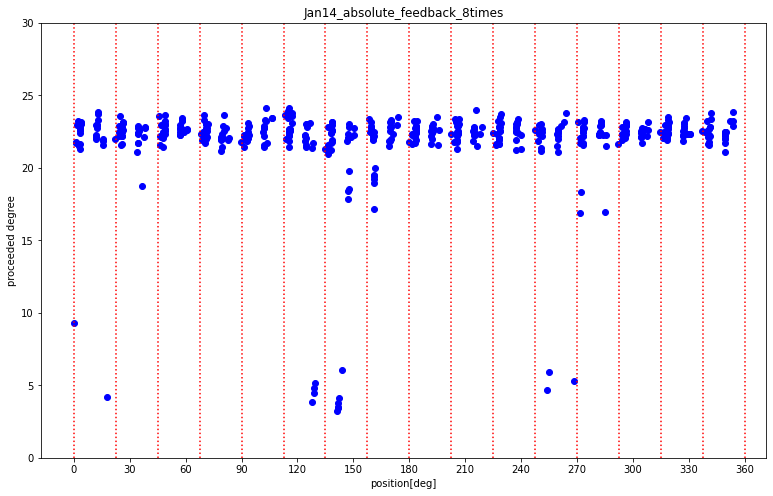

In [83]:
moved_angle = []
end_position = []
peko = []

p1 = 0
p2 = 518

fig21, ax = plt.subplots(figsize=(13,8))
#ax = axarr.ravel()

for i in range(matrix_size):
    moved_angle.append([])
    end_position.append([])
    for j in range(p1,p2):
        #if error_position[i][j] != False:
        hoge = (time_block[i][block_initials[i][j]:block_initials[i][j+1]])-time_block[i][block_initials[i][j]]
        place = min(np.where(hoge >= 23.5)[0])
        moved_angle[i].append((lincount_block[i][block_initials[i][j] + place]-lincount_block[i][block_initials[i][j]])*Deg)
        end_position[i].append(lincount_block[i][block_initials[i][j] + place]%52000*Deg)
        peko.append(j)
        #pass
        pass
    ax.scatter(end_position[i], moved_angle[i], color='b')
#     for l, txt in enumerate(peko):
#         ax.annotate(txt, (end_position[i][l], moved_angle[i][l]))
    pass

ax.set_ylim([0,30])

for i in range(len(np.arange(0,382.5,22.5))):
    ax.axvline(np.arange(0,382.5,22.5)[i], ls=':', color='r')
    pass

ax.xaxis.set_major_locator(tik.MultipleLocator(30))

ax.set_title(f'Jan14_absolute_feedback_8times')
ax.set_xlabel('position[deg]')
ax.set_ylabel('proceeded degree')

Text(0.5, 0, 'proceeded degree')

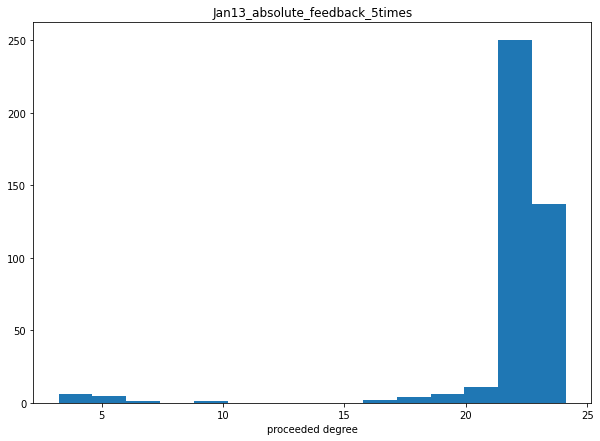

In [42]:
fig30 = plt.figure(figsize=(10,7))

for i in range(matrix_size):
    plt.hist(moved_angle[i], bins=15)
    pass
plt.title(f'Jan13_absolute_feedback_5times')
plt.xlabel('proceeded degree')    

In [338]:
fig30.savefig(storepath + storename + '_histDeg.png', facecolor='white')

In [330]:
movDeg_mean = []
movDeg_stdv = []

for i in range(matrix_size):
    movDeg_mean.append(np.mean(moved_angle[i]))
    movDeg_stdv.append(np.std(moved_angle[i]))
    pass

Text(0, 0.5, 'ratio')

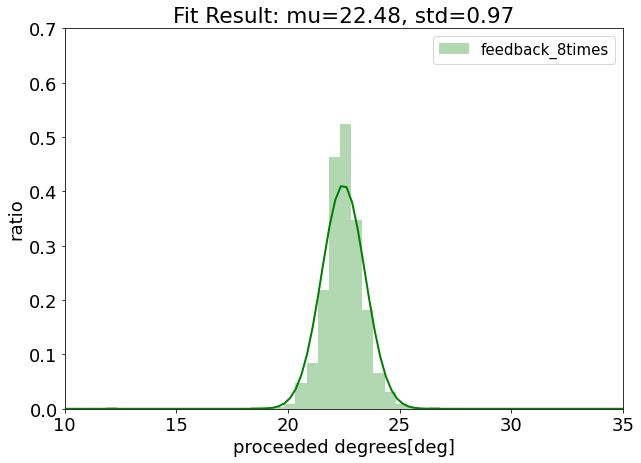

In [136]:
fig40 = plt.figure(figsize=(10,7))
plt.rcParams["font.size"] = 18
mu, std = norm.fit(moved_angle)

# Plot the histogram.
plt.hist(moved_angle, bins=30, density=True, alpha=0.3, color='g', label=f'feedback_8times')
plt.legend(fontsize=15,loc='upper right')

# Plot the PDF.
xmin, xmax = plt.xlim([10,35])
plt.ylim([0.,0.7])
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'g', linewidth=2)
plt.title(f'Fit Result: mu={round(mu,2)}, std={round(std,2)}')
plt.xlabel('proceeded degrees[deg]')
plt.ylabel('ratio')

In [137]:
fig40.savefig(storepath + storename + '_histDEG_FIT0.png', facecolor='white')

(array([0.00181055, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00181055, 0.00362109, 0.03258984, 0.15389646,
        0.49246868, 0.26615035, 0.03983203, 0.00724219, 0.00181055]),
 array([11.84538462, 12.84415385, 13.84292308, 14.84169231, 15.84046154,
        16.83923077, 17.838     , 18.83676923, 19.83553846, 20.83430769,
        21.83307692, 22.83184615, 23.83061538, 24.82938462, 25.82815385,
        26.82692308]),
 <BarContainer object of 15 artists>)

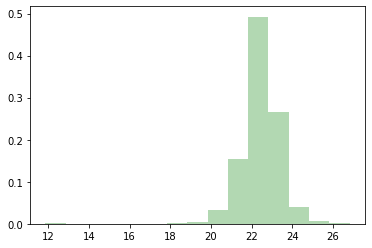

In [49]:
plt.hist(moved_angle, bins=15, density=True, alpha=0.3, color='g', label=f'feedback_5times')

In [62]:
figXX.savefig(storepath + storename + '_DEGvsSTD.png', facecolor='white')

In [41]:
kue = np.arange(0,360,22.5)
kue

array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5, 180. ,
       202.5, 225. , 247.5, 270. , 292.5, 315. , 337.5])

In [42]:
len(kue)

16

In [206]:
len(lincount_block[0])

1601000

In [32]:
fig10.savefig(storepath + storename +'_speed1-avoidERROR.png', facecolor='white')

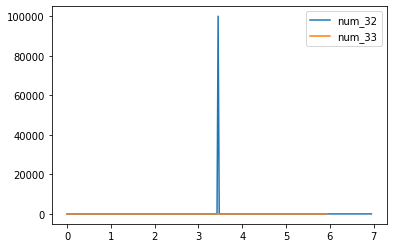

In [23]:
i = 14
for j in range(32,34):
    #if error_position[i][j] != False:
    plt.plot(((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[:-1]-time_block[i][block_initials[i][j]],
                np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice]), label=f'num_{j}')
    plt.legend()

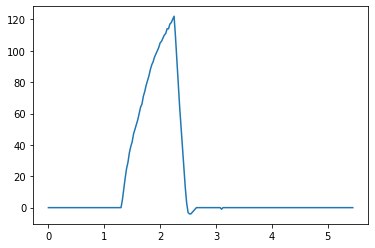

In [20]:
i = 14
j = 20
plt.plot(((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[:-1]-time_block[i][block_initials[i][j]],
        np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice]))

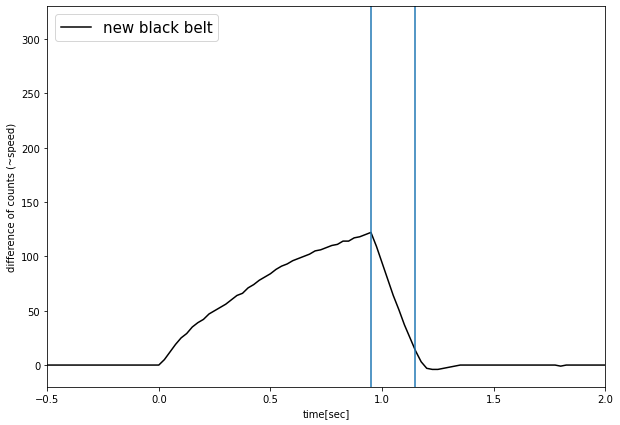

In [80]:
i = 19
j = 20

hoge = np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice]) > 0
fuga = np.where(~hoge[:-1] & hoge[1:])
piyo = ((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[1:]
kue = (((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[1:])[fuga]

figY = plt.figure(figsize=(10,7))

plt.plot(piyo-kue, np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice]), color='k', label='new black belt')
plt.axvline(0.95)
plt.axvline(1.15)
plt.xlabel('time[sec]')
plt.ylabel('difference of counts (~speed)')
plt.xlim([-0.5,2.])
plt.ylim([-20,330])
plt.legend(loc='upper left', fontsize=15)

In [81]:
proceeded_degrees[i][j]

23.26153846153846

In [49]:
figY.savefig(storepath + storename + '_form_21e-1A-1sec_num20.png', transparent=True)

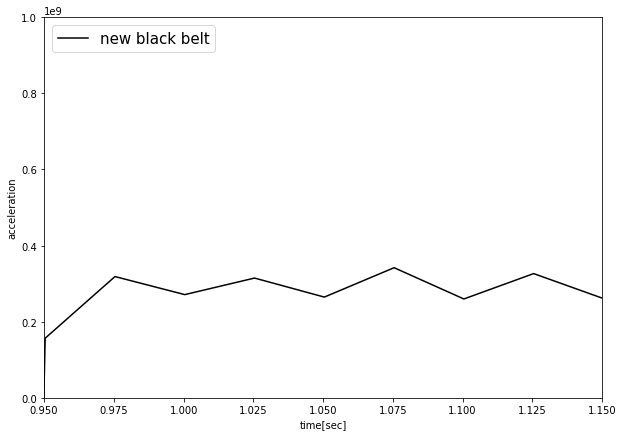

In [79]:
i = 19
j = 20

toki = np.diff(((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice]))
basho = np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])

hoge = np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice]) > 0
fuga = np.where(~hoge[:-1] & hoge[1:])
piyo = ((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[:-1]
kue = (((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[:-1])[fuga]
saku = basho/toki

figY = plt.figure(figsize=(10,7))

plt.plot((piyo-kue)[1:], np.diff(saku)/np.diff(toki), color='k', label='new black belt')
plt.axvline(0)
plt.xlabel('time[sec]')
plt.ylabel('acceleration')
plt.xlim([0.95,1.15])
plt.ylim([-20,1e9])
plt.legend(loc='upper left', fontsize=15)

* <span style="font-size: 200%; color: red;">Here is a check point of analysis.</span>

Text(0.5, 1.0, '3.0A_0.69sec')

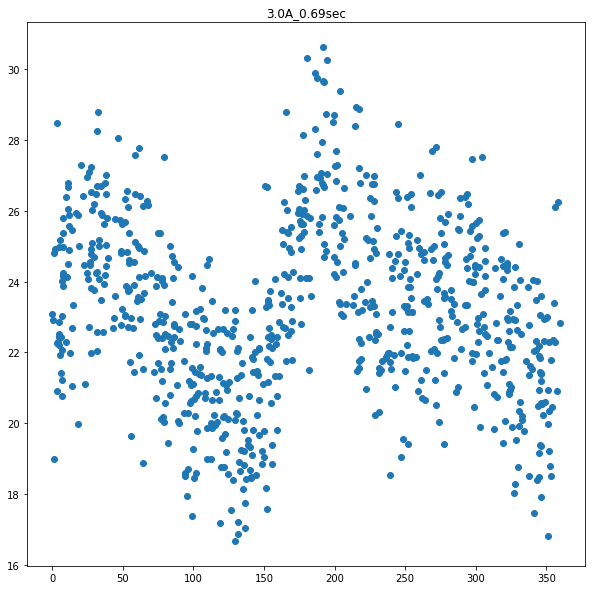

In [38]:
fig11 = plt.figure(figsize=(10,10))

i = 0

plt.scatter(np.array(linCount_woErr[i])%52000*Deg,proDeg_woErr[i])
plt.title('3.0A_0.69sec')

In [45]:
fig11.savefig(storepath + storename + '_POSvsDEG-avoidERROR.png',facecolor='white')

Text(0.5, 1.0, '3.0A_0.69sec')

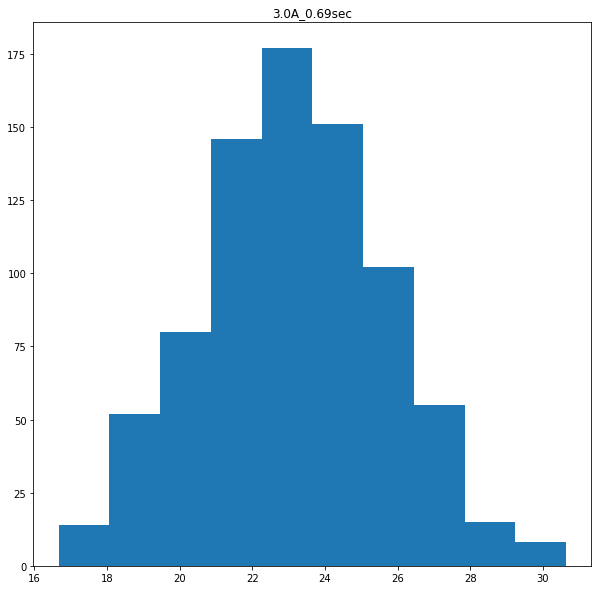

In [39]:
fig12 = plt.figure(figsize=(10,10))

i = 0

plt.hist(proDeg_woErr[i])
plt.title('3.0A_0.69sec')

In [46]:
fig12.savefig(storepath + storename + '_histDEG-avoidERROR.png', facecolor='white')

In [25]:
proDeg_mean = []
proDeg_stdv = []

for i in range(6):
    proDeg_mean.append([])  
    proDeg_stdv.append([])
for i in range(matrix_size):
    proDeg_mean[int(i/6)].append(np.mean(proDeg_woErr[i]))
    proDeg_stdv[int(i/6)].append(np.std(proDeg_woErr[i]))
    pass

Text(0, 0.5, 'number of events')

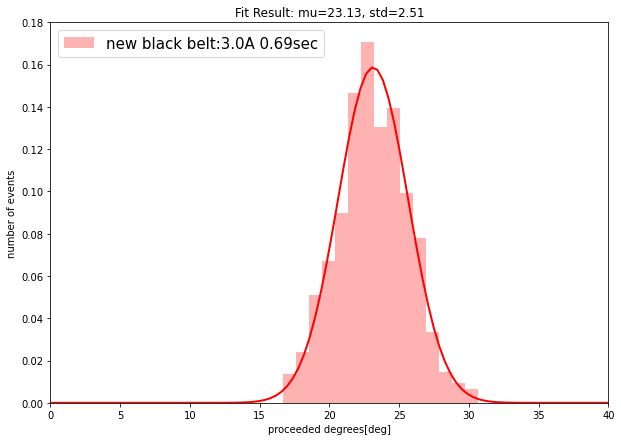

In [48]:
fig14 = plt.figure(figsize=(10,7))
mu, std = norm.fit(proDeg_woErr)

# Plot the histogram.
plt.hist(proDeg_woErr, bins=15, density=True, alpha=0.3, color='r', label='new black belt:3.0A 0.69sec')
plt.legend(fontsize=15,loc='upper left')

# Plot the PDF.
xmin, xmax = plt.xlim([12,34])
plt.ylim([0.,0.18])
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
plt.title(f'Fit Result: mu={round(mu,2)}, std={round(std,2)}')
plt.xlabel('proceeded degrees[deg]')
plt.ylabel('number of events')

In [49]:
fig14.savefig(storepath + storename + '_histDEG_FIT1.png', transparent=True)

(-20.0, 140.0)

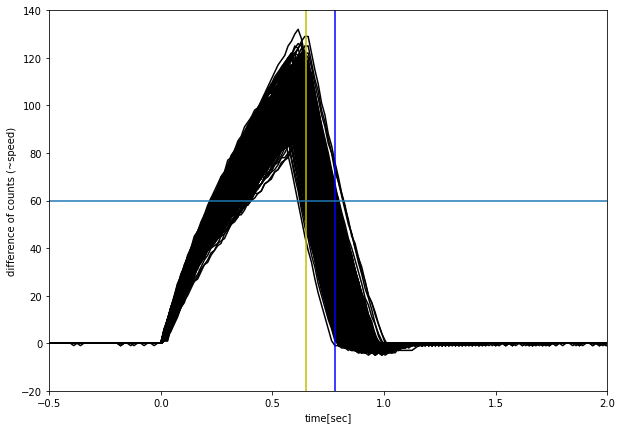

In [112]:
i = 0
hoge = 10
fuga = 500

time0 = []
time1 = []
time2 = []
time3 = []

for j in range(hoge,fuga):
    time0.append([])
    time1.append([])
    time2.append([])
    time3.append([])
    time0[j-hoge] = np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice]) > 0
    time1[j-hoge] = np.where(~time0[j-hoge][:-1] & time0[j-hoge][1:])
    time2[j-hoge] = ((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[1:]
    time3[j-hoge] = (((time_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice])[1:])[time1[j-hoge]]

figY = plt.figure(figsize=(10,7))

for j in range(hoge,fuga):
    plt.plot(time2[j-hoge]-time3[j-hoge], np.diff((lincount_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice]), color='k', label='black belt')
    pass

plt.axvline(0.65, color='y')
plt.axvline(0.78, color='b')
plt.axhline(60)
plt.xlabel('time[sec]')
plt.ylabel('difference of counts (~speed)')
plt.xlim([-0.5,2.])
plt.ylim([-20,140])
#plt.legend(loc='upper right', fontsize=15)

In [104]:
figY.savefig(storepath + storename + '_form_3A-69e-1sec_num10_slice30.png', transparent=True)

In [105]:
kue = (lincount_block[i][block_initials[i][j]:block_initials[i][j+1]])[::plot_slice]

In [107]:
(kue[-1] - kue[0])*Deg

22.07076923076923

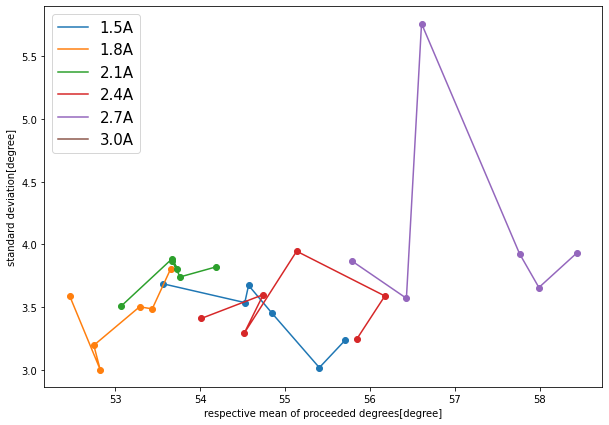

In [27]:
figXX = plt.figure(figsize=(10,7))
for i in range(6):
    plt.plot(proDeg_mean[i], proDeg_stdv[i], label=f'{round(1.5+i*0.3,2)}A')
    plt.scatter(proDeg_mean[i], proDeg_stdv[i])
    pass
plt.xlabel('respective mean of proceeded degrees[degree]')
plt.ylabel('standard deviation[degree]')
# plt.xlim([-30,670])
# plt.ylim([0,16])
# plt.axvline(360)
plt.legend(loc='upper left', fontsize=15)

In [43]:
figXX.savefig(storepath + storename + '_DEGvsSTD0.png', facecolor='white')

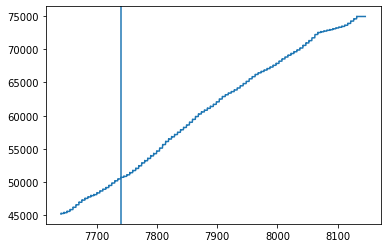

In [145]:
i = 12
plt.plot(time_block[i], lincount_block[i])
plt.axvline(time_block[i][block_initials[i][20]])

In [80]:
linear_refcount = []

specific_refcount = reference_block[12]

for
linear_refcount = np.array(np.zeros(len(specific_refcount)))
    
count_offset = 0
casp_flag = 0
casp = np.where(np.diff(specific_refcount) <= casp_threshold)[0].tolist()

for i in range(len(specific_refcount)):
    linear_refcount[i] = specific_refcount[i]+count_offset
    if casp:
        if i == casp[casp_flag]:
            count_offset += specific_refcount[casp[casp_flag]]
            if len(casp) > casp_flag+1:
                casp_flag += 1
                pass
            pass
        pass
    pass


In [90]:
len(inits[0:100])

100

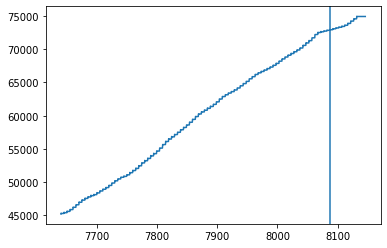

In [98]:
plt.plot(time_block[12], linear_refcount)
plt.axvline((time[::capture_slice])[(inits[1200:1300])[90]])

In [127]:
linear_refcount

array([45225., 45225., 45225., ..., 74916., 74916., 74916.])

In [99]:
hoge = np.where(time_block[12] == (time[::capture_slice])[(inits[1200:1300])[90]])[0]
hoge

array([893000])

In [100]:
(time_block[12])[hoge]

array([8087.35462564])

In [113]:
i = 3
hoge = int(np.where(time_block[i] == (time[::capture_slice])[(inits[i*100:(i+1)*100])[j]])[0])

In [114]:
hoge

1281000

In [117]:
lines = []
for i in range(matrix_size):
    lines.append([])
    for j in range(iteration):
        lines[i].append(int(np.where(time_block[i] == (time[::capture_slice])[(inits[i*100:(i+1)*100])[j]])[0]))

In [119]:
len(lines)

36

In [121]:
lines

[[1000,
  11000,
  21000,
  31000,
  41000,
  51000,
  61000,
  71000,
  81000,
  91000,
  101000,
  111000,
  119000,
  129000,
  139000,
  149000,
  159000,
  169000,
  179000,
  189000,
  199000,
  209000,
  219000,
  229000,
  239000,
  249000,
  259000,
  269000,
  279000,
  289000,
  299000,
  309000,
  319000,
  329000,
  337000,
  347000,
  357000,
  367000,
  377000,
  387000,
  397000,
  407000,
  417000,
  427000,
  437000,
  447000,
  457000,
  467000,
  477000,
  487000,
  497000,
  507000,
  517000,
  527000,
  537000,
  547000,
  555000,
  565000,
  575000,
  585000,
  595000,
  605000,
  615000,
  625000,
  635000,
  645000,
  655000,
  665000,
  675000,
  685000,
  695000,
  705000,
  715000,
  725000,
  735000,
  745000,
  755000,
  765000,
  773000,
  783000,
  793000,
  803000,
  813000,
  823000,
  833000,
  843000,
  853000,
  863000,
  873000,
  883000,
  893000,
  903000,
  913000,
  923000,
  933000,
  943000,
  953000,
  963000,
  973000,
  983000],
 [1000,
  

In [122]:
(time_block[0])[lines[0][0]]

88.69317829

In [123]:
time_block[0][0]

88.193170085

(85.0, 90.0)

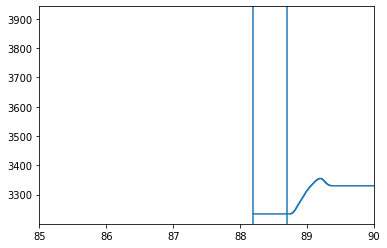

In [126]:
plt.plot(time_block[0], reference_block[0])
plt.axvline((time_block[0])[lines[0][0]])
plt.axvline(time_block[0][0])
plt.xlim([85,90])

In [87]:
0.08e-3*2.5e-9*100/10e-9

0.002

In [56]:
for i in range(10):
    print(f'{(time[::capture_slice])[swt[i]-1]} {(time[::capture_slice])[swt[i]]} {(time[::capture_slice])[swt[i]+1]}')

88.193170085 88.69317829 89.193203115
593.20249172 593.702499575 594.20250796
1154.212569985 1154.71258047 1155.21258944
1756.223303265 1756.72331147 1757.22332254
2413.234984265 2413.734995515 2414.23500378
3111.747427685 3112.24744023 3112.747448585
3864.760772545 3865.260790285 3865.76080831
4369.77194314 4370.271951095 4370.771970175
4930.783288205 4931.2833187 4931.783328565
5532.796416385 5533.29643186 5533.79644037


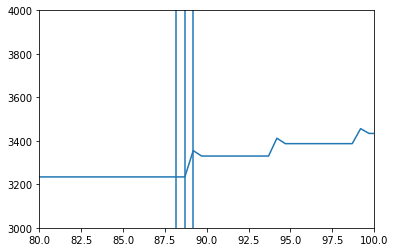

In [60]:
plt.plot(time[::capture_slice], reference[::capture_slice])
plt.xlim([80,100])
plt.ylim([3000,4000])
for i in range(5):
    plt.axvline((time[::capture_slice])[swt[i]-1])
    plt.axvline((time[::capture_slice])[swt[i]])
    plt.axvline((time[::capture_slice])[swt[i]+1])

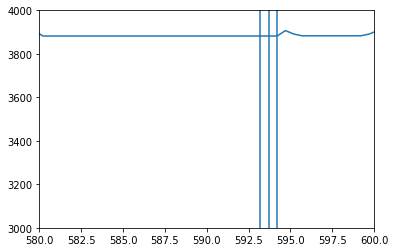

In [61]:
plt.plot(time[::capture_slice], reference[::capture_slice])
plt.xlim([580,600])
plt.ylim([3000,4000])
for i in range(5):
    plt.axvline((time[::capture_slice])[swt[i]-1])
    plt.axvline((time[::capture_slice])[swt[i]])
    plt.axvline((time[::capture_slice])[swt[i]+1])

In [66]:
for i in range(4):
    print(f'{int(np.where(time == (time[::capture_slice])[swt[i]-1])[0])}')

167000
1177000
2299000
3503000


In [67]:
i = 0
hoge = time[int(np.where(time == (time[::capture_slice])[swt[i]-1])[0]):int(np.where(time == (time[::capture_slice])[swt[i+1]-1])[0])]


In [68]:
hoge

array([ 88.19317009,  88.19367009,  88.1941701 , ..., 593.20099147,
       593.20149155, 593.20199156])

In [71]:
len(time_block)

36

In [74]:
for i in range(10):
    print(f'{len(time_block[i])}')

1010000
1122000
1204000
1314000
1397000
1506000
1010000
1122000
1204000
1312000


In [ ]:
linear_refcount = np.array(np.zeros(len(specific_refcount)))
    
count_offset = 0
casp_flag = 0
casp = np.where(np.diff(specific_refcount) <= casp_threshold)[0].tolist()

for i in range(len(specific_refcount)):
    linear_refcount[i] = specific_refcount[i]+count_offset
    if casp:
        if i == casp[casp_flag]:
            count_offset += specific_refcount[casp[casp_flag]]
            if len(casp) > casp_flag+1:
                casp_flag += 1
                pass
            pass
        pass
    pass

modLinear = linear_refcount[::skip]
modTime = specific_time[::skip]

positive = np.diff(modLinear) > 0.
edge_initial = np.array([])
edge_initial = np.where(positive[1:] & ~positive[:-1])[0]
edge_final = np.array([])
rep_edge = np.where(~positive[1:] & positive[:-1])[0]
for i in rep_edge:
    edge_flag = 0
    for j in range(edge_coverage):
        if (np.diff(modLinear))[i+j] == 0:
            edge_flag += 1
            if edge_flag == flag_threshold:
                edge_final = np.append(edge_final, i+j+flag_threshold)
                break
                pass
            pass
        pass

In [46]:
swt

[168,
 1178,
 2300,
 3504,
 4818,
 6215,
 7721,
 8731,
 9853,
 11057,
 12369,
 13767,
 15273,
 16283,
 17403,
 18607,
 19921,
 21317,
 22823,
 23834,
 24954,
 26158,
 27472,
 28868,
 30374,
 31384,
 32506,
 33710,
 35024,
 36419,
 37925,
 38935,
 40057,
 41261,
 42572,
 43968]

In [44]:
inits[-1]

45440

In [45]:
end

45451

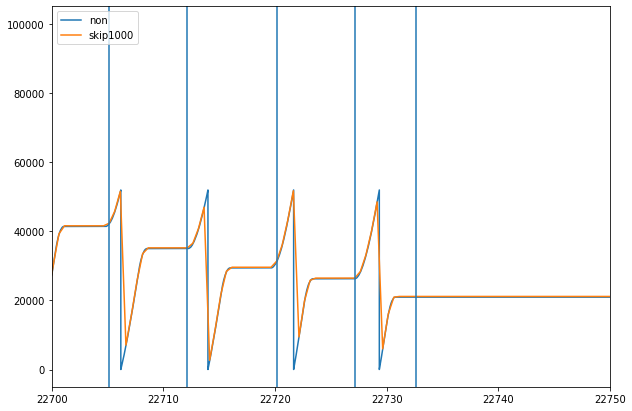

In [27]:
fig = plt.figure(figsize=(10,7))
plt.plot(time, reference, label='non')
#plt.plot(time[::100], reference[::100]+100, label='skip100')
plt.plot(time[::1000], reference[::1000]+200, label='skip1000')
#plt.plot(time[::10000], reference[::10000]+300, label='skip10000')
plt.xlim([22700,22750])
#plt.ylim([0,52000])
for i in range(30):
    plt.axvline((time[::1000])[inits[-i]])
    pass
plt.axvline((time[::1000])[end])
plt.legend(loc='upper left')

In [31]:
len(swt)

6

In [32]:
swt

[[1606733088.0,
  1606733593.0,
  1606734154.0,
  1606734756.0,
  1606735413.0,
  1606736111.0],
 [1606736864.0,
  1606737369.0,
  1606737930.0,
  1606738532.0,
  1606739188.0,
  1606739887.0],
 [1606740640.0,
  1606741145.0,
  1606741705.0,
  1606742307.0,
  1606742964.0,
  1606743662.0],
 [1606744415.0,
  1606744921.0,
  1606745481.0,
  1606746083.0,
  1606746740.0,
  1606747438.0],
 [1606748191.0,
  1606748696.0,
  1606749257.0,
  1606749859.0,
  1606750516.0,
  1606751214.0],
 [1606751967.0,
  1606752472.0,
  1606753033.0,
  1606753635.0,
  1606754291.0,
  1606754989.0]]

In [50]:
time_block = []
reference_block = []

for i in range(len(swt)-1):
    time_block.append((time[::capture_slice])[swt[i]:swt[i+1]])
    reference_block.append((reference[::capture_slice])[swt[i]:swt[i+1]])
    pass
time_block.append((time[::capture_slice])[swt[-1]:end])
reference_block.append((reference[::capture_slice])[swt[-1]:end])

In [52]:
len(time_block)

36

In [53]:
len(reference_block)

36

In [30]:
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 1000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                       df|   3340952|
|                    inits|     30120|
|                     time| 399989696|


In [27]:
#del df, initial_lines, time, rep, hoge

# Plots

In [ ]:
fig10 ,axarr10 = plt.subplots(6,6,figsize=(26,28))
ax10 = axarr10.ravel()

for i in range(matrix_size):
    for j in range(min(len(edge_initial[i]),len(edge_final[i]))):
        #if error_position[i][j] != False:
        ax10[i].plot((linTime[i][:-1])[int(edge_initial[i][j]):int(edge_final[i][j])]-(linTime[i][:-1])[int(edge_initial[i][j])],
                    (np.diff(linRef[i]))[int(edge_initial[i][j]):int(edge_final[i][j])])
        ax10[i].set_title(f'{round((1.2+0.3*int(i/6)),2)}A_{0.5*(1+i%6)}sec')
        #ax10[i].xaxis.set_major_locator(tik.MultipleLocator(0.5))

In [ ]:
#fig10.savefig(storepath + storename +'_speed1.png', facecolor='white')

In [ ]:
i = 0

fig = plt.figure(figsize=(10,7))
#for j in range(min(len(edge_initial[i]),len(edge_final[i]))):
for j in range(0,10):
    #if error_position[i][j] != False:
    plt.plot((linTime[i][:-1])[int(edge_initial[i][j]):int(edge_final[i][j])]-(linTime[i][:-1])[int(edge_initial[i][j])],
                (np.diff(linRef[i]))[int(edge_initial[i][j]):int(edge_final[i][j])])
    plt.title(f'{round((1.2+0.3*int(i/6)),2)}A_{0.5*(1+i%6)}sec')

In [ ]:
fig11 ,axarr11 = plt.subplots(6,6,figsize=(24,22))
ax11 = axarr11.ravel()

for i in range(matrix_size):
    ax11[i].scatter(linInitRef_woErr[i],proDeg_woErr[i], s=20)
    ax11[i].set_title(f'{round((1.2+0.3*int(i/6)),2)}A_{0.5*(1+i%6)}sec')
    pass

In [ ]:
#fig11.savefig(storepath + storename + '_TvsDEG.png', facecolor='white')

In [ ]:
fig12 = plt.figure(figsize=(10,7))
for i in range(matrix_size):
    plt.scatter(linInitRef_woErr[i], proDeg_woErr[i])
    pass
plt.title('2.1A 0.55sec position VS degrees')
plt.xlabel('position[deg]')
plt.ylabel('proceeded degrees[deg]')

In [ ]:
int(len(linInitRef_woErr[0])/16)

In [ ]:
hoge = []
for i in range(int(len(linInitRef_woErr[0])/16)):
    hoge.append(linInitRef_woErr[0][16*i:16*(i+1)])
    pass
#hoge

In [ ]:
360/23

In [ ]:
plt.hist(linInitRef_woErr[0],range=[0,360],bins=15)

In [ ]:
hist_color = ['bisque', 'lightgreen', 'skyblue']
fuga = []
for i in range(int(len(linInitRef_woErr[0])/16)):
    fuga.append(hist_color[i%3])

In [ ]:
fig = plt.figure(figsize=(10,7))
plt.hist(hoge,range=[0,360],bins=15,stacked=True,color=fuga)

In [ ]:
#fig12.savefig(storepath + storename + '_POSvsDEG.png', facecolor='white')

In [ ]:
fig13 = plt.figure()
for i in range(matrix_size):
    plt.hist(proDeg_woErr[i], bins=15)
    pass
plt.title('2.1A 0.55sec proceeded degrees hist')
plt.xlabel('proceeded degrees[deg]')
plt.ylabel('number of events')

In [ ]:
#fig13.savefig(storepath + storename + '_histDEG.png', facecolor='white')

In [ ]:
#Fitting histogram
fig14 = plt.figure(figsize=(10,7))
mu, std = norm.fit(proDeg_woErr)

# Plot the histogram.
plt.hist(proDeg_woErr, bins=15, density=True, alpha=0.3, color='g', label='2.1A 0.55sec')
plt.legend(fontsize=15,loc='upper right')

# Plot the PDF.
xmin, xmax = plt.xlim([0,40])
plt.ylim([0.,0.18])
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title(f'Fit Result: mu={round(mu,2)}, std={round(std,2)}')
plt.xlabel('proceeded degrees[deg]')
plt.ylabel('number of events')

In [ ]:
#fig14.savefig(storepath + storename + '_histDEG_FIT0.png', facecolor='white')

# Others